Script from Chelsey to read classifier results

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
import pickle
import glob
import AZKABANML

### Plotting settings

In [3]:

palette = sns.color_palette('colorblind')
plt.style.use(['seaborn-colorblind'])
plt.rc('font', family='Arial')
SMALL_SIZE = 12
BIGGER_SIZE = 14
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.direction'] = 'inout'
plt.rcParams['ytick.direction'] = 'inout'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.width'] = 1

savefigs_path = 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/Figs/'

one_col = 85 *0.0393701
two_col = 170*0.0393701

np.set_printoptions(formatter={'float': lambda x: "{0:0.1f}".format(x)})

### Read results for any classifier

In [7]:
path = r'F:/Nya-AZKABAN/Classify/'
path_df = 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/'

model_df = pd.read_pickle(path_df+'df_sim_smooth.pkl')
model_df = model_df.replace('Hydrozoan', 'Hydrozoans')

# Read results

In [8]:
kNN_norm = AZKABANML.read_results_all('kNN_14-06-2023_smooth_norm',path)

SVM = AZKABANML.read_results_all('SVC_14-06-2023_smooth_norm',path)

LightGBM = AZKABANML.read_results_all('lightGBM_14-06-2023_smooth_norm',path)


# Match to tracked detections export

In [9]:
ts_track_path = path_df+"SED_ZoopMix_FTwindow33pl_tracks.csv" 

In [10]:
trackedSED_df = AZKABANML.tsf_targets_import(ts_track_path)

In [11]:
trackedSED_df['Prediction_kNN'] = kNN_norm['predtrack_df']['Prediction']
trackedSED_df['Prediction_LightGBM'] = LightGBM['predtrack_df']['Prediction']
trackedSED_df['Prediction_SVM'] = SVM['predtrack_df']['Prediction']

# Compare

#### How much do the predictions agree?

In [12]:
agree_ind = np.where((trackedSED_df['Prediction_LightGBM']==trackedSED_df['Prediction_SVM'])& (trackedSED_df['Prediction_LightGBM']==trackedSED_df['Prediction_kNN']))
agree_total = len(agree_ind[0])
total = len(trackedSED_df)
print(f'{str(agree_total/total*100):.5}% of predictions({agree_total} samples) consistent between the three classifiers')

18.13% of predictions(1400 samples) consistent between the three classifiers


In [13]:
trackedSED_df['Prediction_kNN'].iloc[agree_ind].value_counts()/total*100

Hydrozoan       10.903911
Chaetognaths     5.931106
Euphausiids      1.295001
Name: Prediction_kNN, dtype: float64

Pair wise comparisons

In [14]:
agree_ind = np.where((trackedSED_df['Prediction_LightGBM']==trackedSED_df['Prediction_kNN']))
agree_total = len(agree_ind[0])
total = len(trackedSED_df)
print(f'{str(agree_total/total*100):.5}% of predictions ({agree_total} samples) consistent between kNN and LightGBM')

42.55% of predictions (3286 samples) consistent between kNN and LightGBM


In [15]:
agree_ind = np.where((trackedSED_df['Prediction_LightGBM']==trackedSED_df['Prediction_SVM']))
agree_total = len(agree_ind[0])
total = len(trackedSED_df)
print(f'{str(agree_total/total*100):.5}% of predictions ({agree_total} samples) consistent between LightGBM and SVM')

29.31% of predictions (2264 samples) consistent between LightGBM and SVM


In [16]:
agree_ind = np.where((trackedSED_df['Prediction_kNN']==trackedSED_df['Prediction_SVM']))
agree_total = len(agree_ind[0])
total = len(trackedSED_df)
print(f'{str(agree_total/total*100):.5}% of predictions ({agree_total} samples) consistent between kNN and SVM')

50.62% of predictions (3909 samples) consistent between kNN and SVM


#### How consistent is it per track?

In [37]:
kNN_track = trackedSED_df.groupby(['Region_name'])['Prediction_kNN'].value_counts()
LightGBM_track = trackedSED_df.groupby(['Region_name'])['Prediction_LightGBM'].value_counts()
SVM_track = trackedSED_df.groupby(['Region_name'])['Prediction_SVM'].value_counts()

kNN_track = kNN_track.unstack(level=-1)
LightGBM_track = LightGBM_track.unstack(level=-1)
SVM_track = SVM_track.unstack(level=-1)

In [38]:
kNN = kNN_track.divide(trackedSED_df.groupby(['Region_name'])['Prediction_kNN'].count().values,axis=0)*100
LGBM = LightGBM_track.divide(trackedSED_df.groupby(['Region_name'])['Prediction_LightGBM'].count().values,axis=0)*100
SVM = SVM_track.divide(trackedSED_df.groupby(['Region_name'])['Prediction_SVM'].count().values,axis=0)*100

[Text(0, 0.5, 'Majority class votes per track (%)')]

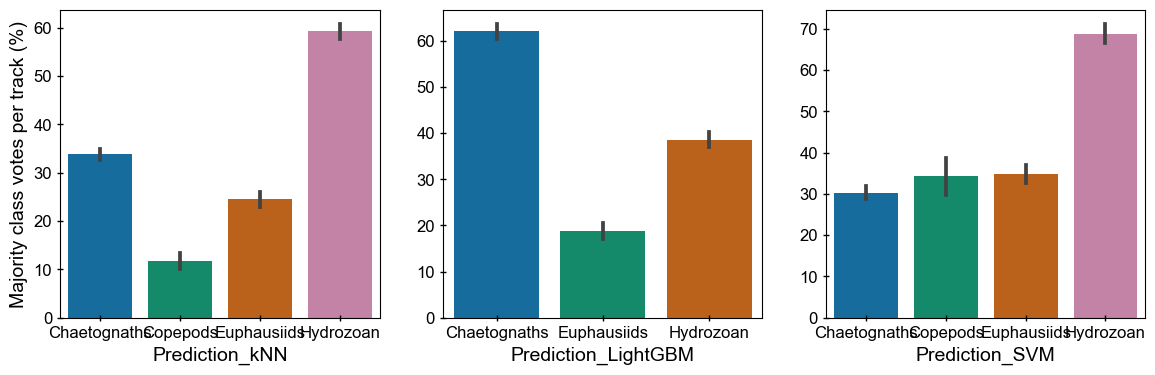

In [39]:
fig, ax = plt.subplots(1,3, figsize=(14,4))
sns.barplot(data=kNN, ax=ax[0])
sns.barplot(data=LGBM, ax=ax[1])
sns.barplot(data=SVM, ax=ax[2])
ax[0].set(ylabel='Majority class votes per track (%)')

# Majority class consistency

In [40]:
kNN_maj = np.max(kNN,axis=1).mean()
kNN_sd = np.max(kNN,axis=1).std()

LightGBM_maj = np.max(LGBM,axis=1).mean()
LightGBM_sd = np.max(LGBM,axis=1).std()

SVM_maj = np.max(SVM,axis=1).mean()
SVM_sd = np.max(SVM,axis=1).std()

In [41]:
print(f'The majority class of each class had an average consistency of {kNN_maj:.4}+-{kNN_sd:.4}% for kNN, {LightGBM_maj:.4}+-{LightGBM_sd:.4}% for LightGBM and {SVM_maj:.4}+-{SVM_sd:.4}% for SVM.')

The majority class of each class had an average consistency of 64.3+-16.22% for kNN, 69.49+-16.18% for LightGBM and 74.92+-21.08% for SVM.


We selected rigourous track detection parameters and did some visual quality check, therefore we would expect a higher track consistency from a successful classifier.

In [42]:
np.max(kNN,axis=1)

Region_name
Region 1      38.181818
Region 10     94.117647
Region 100    60.000000
Region 101    61.538462
Region 102    50.000000
                ...    
Region 95     61.538462
Region 96     56.250000
Region 97     50.000000
Region 98     78.260870
Region 99     50.000000
Length: 777, dtype: float64

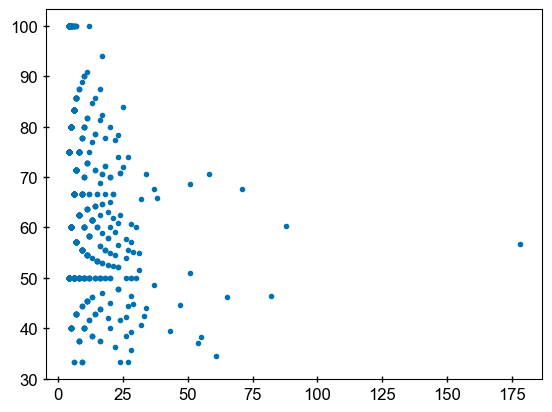

In [48]:
plt.plot(trackedSED_df.groupby(['Region_name'])['Prediction_kNN'].count().values,np.max(kNN,axis=1), '.')

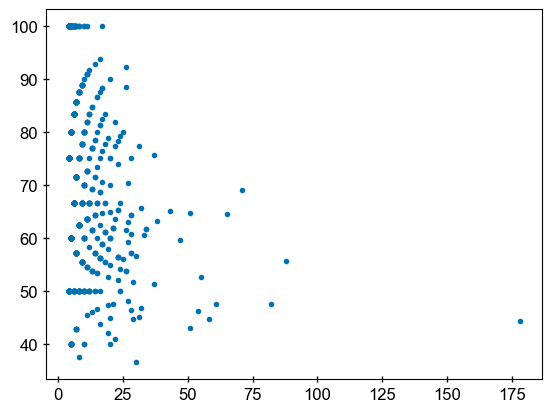

In [51]:
plt.plot(trackedSED_df.groupby(['Region_name'])['Prediction_LightGBM'].count().values,np.max(LGBM,axis=1), '.')

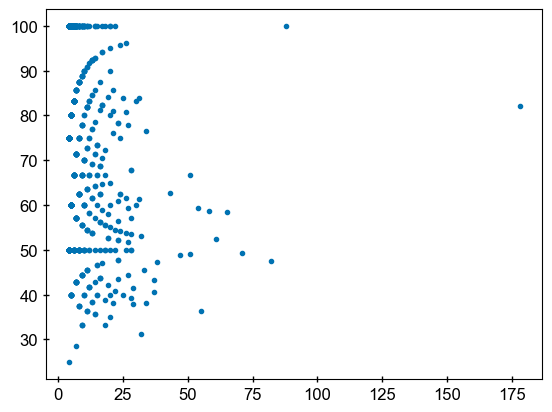

In [52]:
plt.plot(trackedSED_df.groupby(['Region_name'])['Prediction_SVM'].count().values,np.max(SVM,axis=1), '.')